In [2]:
library(tidyverse)
library(readxl)
library(ggplot2)
library(cowplot)
library(tidymodels)
library(repr)
library(dplyr)

### Predictive Analytics for Knowledge Level Assessment: An Integrated Approach Using Classification and Performance Metrics

#### Introduction:

To what extent exam performance dictates an individual’s knowledge level has been a longstanding inquiry in educational research. In this project, we aim to explore this question by delving into a dataset focused on assessing students' knowledge status in the subject of **Electrical DC Machines**. Our objective is to uncover the correlation between one’s knowledge level (UNS) and several factors:

`STG` The degree of study time for goal object materials

`STR` The degree of study time of user for related objects with goal object

`LPR` The exam performance of user for related objects with goal object

`PEG` The exam performance of user for goal objects

>By analyzing this dataset, we aim to clearly discern the classification of users' knowledge levels across the defined categories: *very_low, Low, Middle, and High*. Understanding these knowledge levels is crucial for optimizing educational strategies and interventions in this particular subject.

**Research Question:**

Is it accurate to predict a student's knowledge level (`UNS`) based  on their `STG`,`STR`, `LPR`, and`PEG`?

In [3]:
set.seed(1)
url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
temp <- tempfile()
temp2 <- tempfile()

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
data_training <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 2) #training data
data_testing <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 3)  #testing data
unlink(c(temp, temp2))


knowledge_testing <- select(data_testing, STG:UNS) |>
    mutate(UNS = as_factor(UNS)) |>
    mutate(UNS = factor(UNS, levels = c("Very Low", "High", "Low", "Middle")))

knowledge_training <- select(data_training, STG:UNS) |> #selected useful columns
    mutate(UNS = as_factor(UNS)) |>
    mutate(UNS = recode(UNS, very_low = "Very Low")) |>
    mutate(UNS = factor(UNS, levels = c("Very Low", "High", "Low", "Middle")))
slice(knowledge_training, 1:10) #sliced so as not to clog screen 

summary_knowledge_training <- knowledge_training |>   # this table shows the total amount of observations per knowledge lvl
    group_by(UNS) |>                                  # and the mean values for each predictor for each knowledge lvl
    summarize(count = n(),
             STG_mean = mean(STG),
             STR_mean = mean(STR),
             LPR_mean = mean(LPR),
             PEG_mean = mean(PEG))

summary_knowledge_training

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,Very Low
0.20,0.14,0.35,0.72,0.25,Low


UNS,count,STG_mean,STR_mean,LPR_mean,PEG_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Very Low,24,0.3057917,0.3662500,0.3587500,0.09083333
High,63,0.4216508,0.5016667,0.5012698,0.77253968
Low,83,0.3211446,0.4307229,0.4973494,0.23762651
Middle,88,0.3999773,0.5068182,0.3428409,0.54238636


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


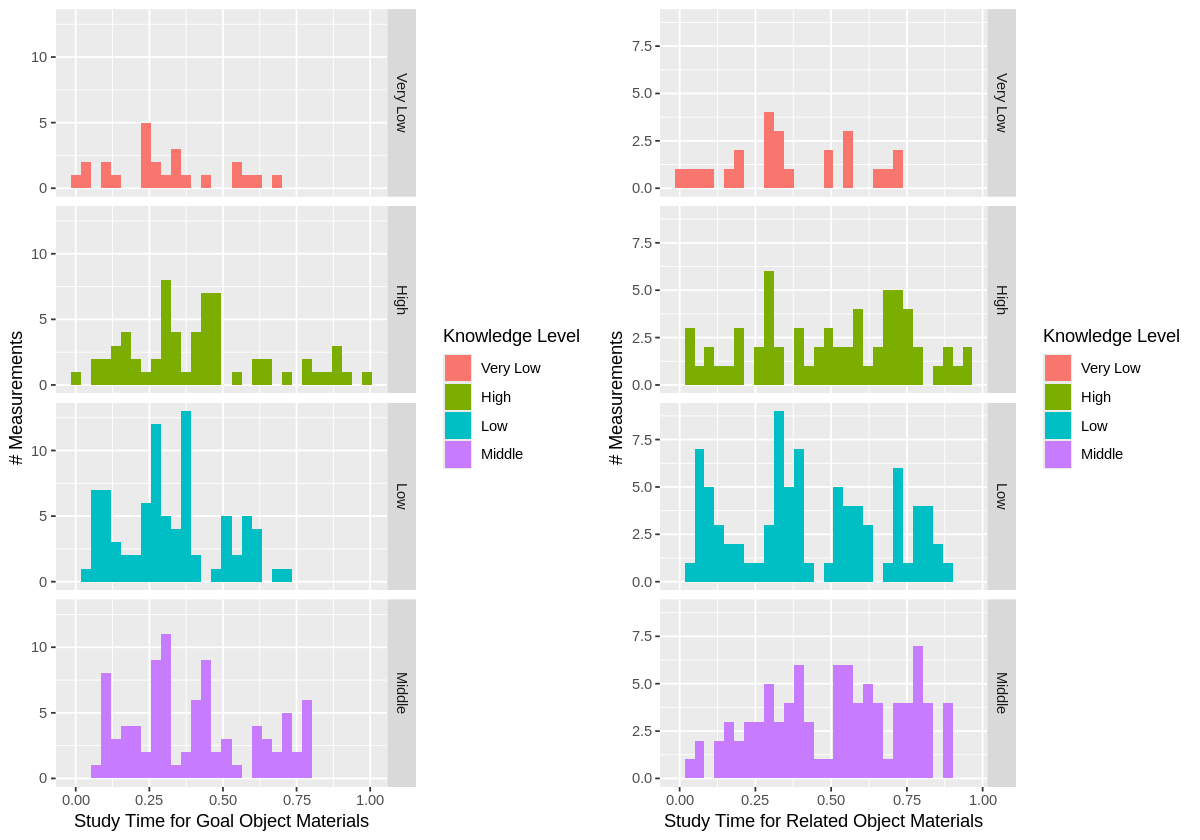

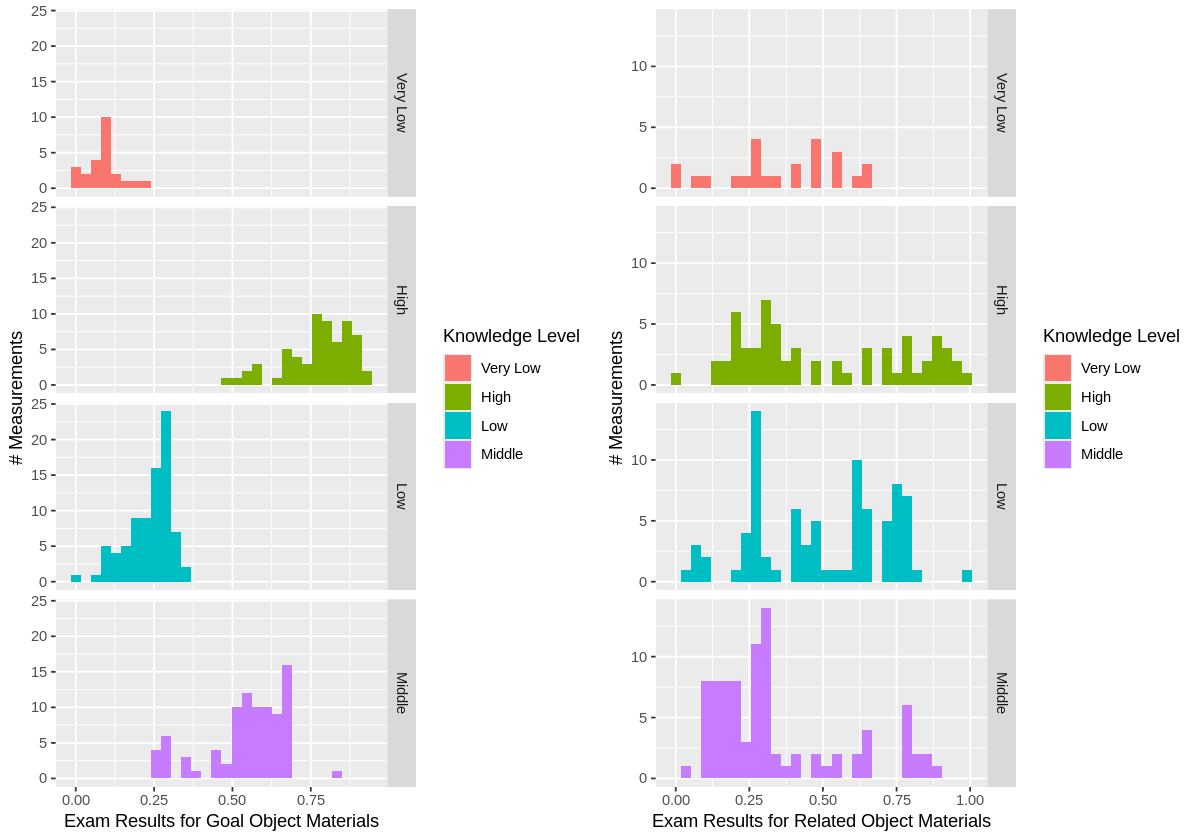

In [4]:
options(repr.plot.width = 10, repr.plot.height = 7)
knowledge_STG_hist <- ggplot(knowledge_training, aes(x = STG, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Goal Object Materials", y = "# Measurements", fill = "Knowledge Level")

knowledge_STR_hist <- ggplot(knowledge_training, aes(x = STR, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Related Object Materials", y = "# Measurements", fill = "Knowledge Level")




knowledge_PEG_hist <- ggplot(knowledge_training, aes(x = PEG, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Exam Results for Goal Object Materials", y = "# Measurements", fill = "Knowledge Level")




knowledge_LPR_hist <- ggplot(knowledge_training, aes(x = LPR, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Exam Results for Related Object Materials", y = "# Measurements", fill = "Knowledge Level")

plot_grid(knowledge_STG_hist, knowledge_STR_hist)  # plots showing the distributions of each predictor
plot_grid(knowledge_PEG_hist, knowledge_LPR_hist)

#### Data Analysis

**Tuning the Classifier**

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8758621


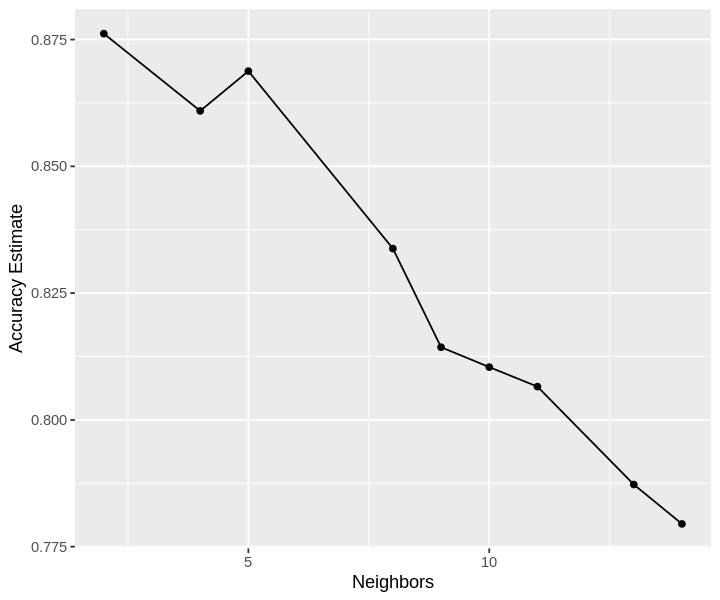

In [8]:
set.seed(1)
options(repr.plot.width = 6, repr.plot.height = 5)

knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = UNS) # performing cross-validation to find best k value

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knowledge_recipe <- recipe(UNS ~ STG + STR + PEG + LPR, data = knowledge_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_results <- workflow() |>   
    add_recipe(knowledge_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = knowledge_vfold, grid = 10) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_vs_k

best_k <- accuracies |> # best k value found is k = 2
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> # evaluating model on test set
    set_engine("kknn") |>
    set_mode("classification")

knowledge_fit <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knowledge_spec) |>
    fit(data = knowledge_training) 

knowledge_predictions <- predict(knowledge_fit, knowledge_testing) |> 
    bind_cols(knowledge_testing) |>
    metrics(truth = UNS, estimate = .pred_class) |>
    filter(.metric == "accuracy")

knowledge_predictions

#### Methods:Our data analysis approach entails the careful selection of pertinent variables for prediction. Specifically, the columns selected for prediction are STG, STR, PEG, and PEG (as defined in the introduction) all serving as predictors for an individual’s knowledge level.

In preparation for our analysis, we divided our dataset into training and testing sets. This division allows us to train our classification model on one portion of the data and evaluate its performance on an independent set, providing insights into the model's generalization capabilities.

For the visualization of the classification results, we will leverage a confusion matrix, providing a comprehensive overview of the model's performance with the counts of true positive, true negative, false positive, and false negative predictions for each class within the predicted variable. In this case, the predicted variable is the "knowledge level," and the confusion matrix offers an insightful representation of the classification results across the various knowledge levels.

Additionally, our results will be measured by accuracy, precision, and recall, providing a quantitative evaluation of the classification model's overall correctness, precision in predictions, and ability to capture relevant instances, respectively. These metrics further contribute to a comprehensive assessment of the model's performance.rmance.

#### Expected outcomes and significance:

Through our data analysis, we are expected to find a positive correlation with exam study time and an individual's knowledge level, regardless of the study material. This outcome may propose potential amendments to current educational practices. Recognizing the importance of study time may increase the significance of early student support services such as resources to help manage and sustain study schedules to help promote effective study habits that would significantly benefit them in higher education. 

Moreover, our analysis could be extended to analyze potential individual differences, such as influences of prior knowledge and cognitive abilities, which may alter one's knowledge level. We could also explore various study methods that may yield insight into which study method is most effective for retaining information over a prolonged period.